In [26]:
import os, sys
import json
import random
import pickle
from typing import List, Tuple, Dict

from itertools import product
import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertModel
# from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import Dataset_Reader, label_encode
from tqdm import tqdm

In [27]:
def save_model(model, filepath):
    """
    Save PyTorch model parameters to a file.

    Args:
    - model (torch.nn.Module): PyTorch model to save.
    - filepath (str): Filepath to save the model parameters.
    """
    torch.save(model.state_dict(), filepath)
    print(f"Model parameters saved to '{filepath}'")

def load_model(model, filepath):
    """
    Load PyTorch model parameters from a file.

    Args:
    - model (torch.nn.Module): PyTorch model to load parameters into.
    - filepath (str): Filepath to the saved model parameters.
    """
    model.load_state_dict(torch.load(filepath))
    print(f"Model parameters loaded from '{filepath}'")
    
def save_tensor(tensor, dir, filename):
    """
    Save PyTorch tensor to a file.

    Args:
    - tensor (torch.Tensor): PyTorch tensor to save.
    - dir (str): Directory to save the tensor.
    - filename (str): Filename to save the tensor.
    """
    
    if not os.path.exists(os.path.join(dir)):
        os.makedirs(os.path.join(dir))
        
    filepath = os.path.join(dir, filename)
    torch.save(tensor, filepath)
    print(f"Tensor saved to '{filepath}'")

def load_tensor(filepath):
    """
    Load PyTorch tensor from a file.

    Args:
    - filepath (str): Filepath to the saved tensor.

    Returns:
    - tensor (torch.Tensor): Loaded PyTorch tensor.
    """
    tensor = torch.load(filepath)
    # print(f"Tensor loaded from '{filepath}'")
    return tensor

In [28]:
with open('../data/train.json', 'r') as file:
    train_data = json.load(file)

with open('../data/dev.json', 'r') as file:
    test_data = json.load(file)

In [4]:
TRAIN_data = Dataset_Reader(train_data)
TEST_data = Dataset_Reader(test_data)
print(len(TRAIN_data))
# TRAIN_data_batched = DataLoader(TRAIN_data, batch_size = 5, shuffle= True)

247


In [8]:
def max_length(documents, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
    """
    Generate the maximum length of each sentence in each document. This is necessary to make sure there is a fixed sentence-length 
    for each document before we pass the sentence embeddings through the model.

    Returns: {document index: length of longest sentence}

    """
    max_l_dict = {}
    
    for sentence in documents.texts:
        size = []

        inputs = tokenizer(sentence[2], return_tensors="pt", truncation=True, padding=True, add_special_tokens= True)

        size.append(inputs['input_ids'].size(1))
        
        max_l_dict[sentence[0]] = max(size)
    
    dict_keys = list(max_l_dict.keys())
    reference_keys = list(range(len(documents)))  
    for key in reference_keys:
        if key not in dict_keys:
            max_l_dict[key] = 0
            
    return max_l_dict

In [9]:
def get_batched_data(data: Dataset, batch_size:int = 1) ->  Tuple[List,List,List]:
    doc_idx = []
    batched_texts = []
    batched_labels = []
    for start, stop in zip(range(0,len(data)-batch_size,batch_size), range(batch_size,len(data),batch_size)):
        idxs = []
        texts = []
        labels = []
        for idx in range(start,stop):
            idxs.append(idx) 
            [texts.append(text) for text in data[idx]['text']]
            [labels.append(label) for label in data[idx]['label']]
        
        doc_idx.append(idxs)
        batched_texts.append(texts)
        batched_labels.append(labels)
    return doc_idx, batched_texts, batched_labels

In [10]:
max_lens_train = max_length(TRAIN_data)

In [11]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 1)

In [12]:
def label_encode(target_variables : list) -> LabelEncoder:
    """
    Encode target variables.
    
    Args:
    - target_variables (list or array-like): List of target variable strings.
    
    Returns:
    - lb (object): class object used to tranform and inverse transform.
    """
    le = LabelEncoder()
    le = le.fit(target_variables)
    
    return le

def get_model_data(data:torch.utils.data.Dataset, encoder: LabelEncoder,
                   tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                   model= BertModel.from_pretrained('bert-base-uncased'),
                   num_of_docs:int = None,
                   ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(data.labels)
    sent_emb = []
    max_sent_length = 128
    if num_of_docs is None:
        for idx, sentence in enumerate(data.texts):
            inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                padding='max_length', max_length = max_sent_length,
                                add_special_tokens= True)
            with torch.no_grad():
                output = model(**inputs)
            sent_emb.append(output.last_hidden_state[:,0,:])
    else:
        for idx, sentence in enumerate(data.texts):
            if sentence[0] < num_of_docs:
                inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                    padding='max_length', max_length = max_sent_length,
                                    add_special_tokens= True)
                with torch.no_grad():
                    output = model(**inputs)
                sent_emb.append(output.last_hidden_state[:,0,:]) 
        numerical_labels = numerical_labels[:len(sent_emb)]
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train

def get_model_data_batched(indexes:List, texts:List, labels:List, encoder:LabelEncoder,max_len_dict:Dict,
                           tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                           model= BertModel.from_pretrained('bert-base-uncased'),
                           ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(labels)
    sent_emb = []
    for idx, sentence in enumerate(texts):
        try:
            max_sent_length = max([max_len_dict[i] for i in indexes])
        except KeyError:
            continue
        inputs = tokenizer(sentence.lower(),  return_tensors="pt", truncation= True,
                            padding='max_length', max_length = max_sent_length,
                            add_special_tokens= True)
        with torch.no_grad():
            output = model(**inputs)
        sent_emb.append(output.last_hidden_state[:,0,:])
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train    
    


In [6]:
list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder = label_encode(list_of_targets)

NameError: name 'label_encode' is not defined

In [115]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Dropout(p=dropout),
                                   nn.Linear(hidden_size*2, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1))
        
        self.apply(init_weights)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        lstm_out, _ = self.bilstm(x.squeeze(0))

        # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [14]:
# TRAIN_emb, TRAIN_labels = get_model_data(data= TRAIN_data, encoder= label_encoder, num_of_docs= 10)
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)

In [15]:
def train(x_train, y_train, model, optimizer, loss_fc, num_epochs):
    model.train()
    loss_list = []
    acc_list = []
    model.train()
    # print(f'{"Starting Training":-^100}')
    for epoch in range(num_epochs+1):
        output = model(x_train)
        loss = loss_fc(output,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if epoch%50 == 0:
            acc = sum(output.argmax(dim=1) == y_train)/ output.size(0)
            acc_list.append(acc)
            print(f"Epoch: {epoch} \t Loss: {loss.item():.5f} \t Accuracy: {acc*100:.2f}%")
            
    return loss_list, acc_list
            
def test_accuracy(x_test, y_test, model):
    model.eval()
    output = model(x_test)
    acc = sum(output.argmax(dim=1) == y_test)/ output.size(0)
    print(f"Test Accuracy {acc*100:.2f}%")
    return acc*100

In [8]:
def set_highest_to_one(tensor):
    max_val, max_idx = tensor.max(dim=1, keepdim=True)
    result = torch.zeros_like(tensor)
    result.scatter_(1, max_idx, 1)
    return result

In [119]:
def class_accuracy(conf_matrix):
    """
    Calculate accuracy for each class based on a confusion matrix.

    Parameters:
    conf_matrix (numpy.ndarray): Confusion matrix.

    Returns:
    list: List of accuracies for each class.
    """
    # diagonal = np.diag(conf_matrix)

    # row_sums = conf_matrix.sum(axis=1)

    # accuracies = diagonal / row_sums.astype(float)

    # return accuracies
    
    diagonal = np.diag(conf_matrix)
    row_sums = conf_matrix.sum(axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        accuracies = np.where(row_sums != 0, diagonal / row_sums.astype(float), 0.0)

    return accuracies

In [120]:
def class_f1_score(conf_matrix, epsilon=1e-7):
    """
    Calculate F1 score for each class based on a confusion matrix.

    Parameters:
    conf_matrix (numpy.ndarray): Confusion matrix.
    epsilon (float): Smoothing term to avoid division by zero.

    Returns:
    list: List of F1 scores for each class.
    """
    
    tp = np.diag(conf_matrix)
    fp = conf_matrix.sum(axis=0) - tp
    fn = conf_matrix.sum(axis=1) - tp

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1_scores

In [126]:
def confusion_matrix(y_pred, y_true, num_classes):
    """
    Create a confusion matrix for label encodings in PyTorch.

    Parameters:
    y_pred (torch.Tensor): Predicted labels tensor.
    y_true (torch.Tensor): True labels tensor.
    num_classes (int): Number of classes.

    Returns:
    numpy.ndarray: Confusion matrix.
    """ 
    # if len(y_pred) != len(y_true):
    #     raise ValueError("Shapes of predictions and true labels must match. y_pred shape: {} y_true shape: {}".format(y_pred.shape, y_true.shape))

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    y_pred_np = y_pred.argmax(dim=1).cpu().numpy()
    y_true_np = y_true.cpu().numpy()

    for pred, true in zip(y_pred_np, y_true_np):
        conf_matrix[pred, true] += 1

    return conf_matrix

In [12]:
def grid_search(parameters):
    keys = parameters.keys()
    values = parameters.values()
    
    combinations = list(product(*values))
    
    parameter_configurations = [{k: v for k, v in zip(keys, combination)} for combination in combinations]
    
    return parameter_configurations

In [13]:
def random_train_test_split(size, training_data_size):
    indices = np.arange(size)
    np.random.shuffle(indices)
    training_data_length = int(size * training_data_size)
    training_data_indices = indices[:training_data_length]
    test_data_indices = indices[training_data_length:]
    return training_data_indices, test_data_indices

In [14]:
def get_accuracy_value(item):
    return item[1][0]

In [15]:
def calculate_confusion_matrix(test_emb, test_labels, model):
    model.eval()
    output = model(test_emb)
    return confusion_matrix(output, test_labels, 13)

In [22]:
def grid_search_train_test(parameters):
    result = []
    parameter_configs = grid_search(parameters)
    
    for config in parameter_configs:
        # batch_loss, batch_acc = [], []
        model = BiLSTM(hidden_size=config['hidden_size'], num_layers=config['num_layers'], dropout=config['dropout'])
        model_opt = torch.optim.Adam(model.parameters(), lr= config['learning_rate'])
        loss_function = nn.CrossEntropyLoss()
        print("Working with: ")
        print(config)
        print("\n")
        
        
        print(f'{"Starting Training":-^100}')
        model.train()
        for epoch in tqdm(range(config['epochs'])):
            # print(f"Epoch {epoch}")
            for idx in range(246):
                TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
                TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
                if TRAIN_emb.size(0) == 0:
                    continue
                output = model(TRAIN_emb)
                loss = loss_function(output,TRAIN_labels)
                
                model_opt.zero_grad()
                loss.backward()
                model_opt.step()
                
            # print(f"Epoch: {epoch+1} \t Loss: {loss.item():.5f}")
            # batch_loss.append(loss.item())
        
        confusion_matrix = None
        for i in range(29):
            TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
            TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
            conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model)
            if confusion_matrix is None:
                confusion_matrix = conf_matrix_helper
            else:
                confusion_matrix = np.add(confusion_matrix, conf_matrix_helper)
                
        accuracies = class_accuracy(confusion_matrix)
        f1_scores = class_f1_score(confusion_matrix)
        average_accuracy = np.mean(accuracies)
        average_f1 = np.mean(f1_scores)
        
        print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
        print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))
        
        result.append((config, (average_accuracy, average_f1)))
        
    return result

In [25]:
parameter_configs = {
    'epochs': [10, 30, 50],
    'learning_rate': [2e-4, 2e-5, 2e-6],
    'dropout': [0.0, 0.1, 0.2],
    'hidden_size': [64, 128, 256],
    'num_layers': [1]
    }

result = grid_search_train_test(parameter_configs)

max_accuracy_config = max(result, key=get_accuracy_value)

print(max_accuracy_config)

Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:52<00:00, 17.22s/it]


Accuracies: [0.67148014 0.         0.         0.74926686 0.         0.90410959
 0.86724138 0.         0.         0.         0.         0.56834532
 0.        ] 
 Average acccuracy: 0.28926486912822064
F1 Scores: [0.78813554 0.         0.         0.81046783 0.         0.5019011
 0.92804423 0.         0.         0.         0.         0.69603519
 0.        ] 
 Average F1: 0.2865064540320977
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:17<00:00, 13.73s/it]


Accuracies: [0.62704115 0.         0.         0.79963899 0.         0.94117647
 0.98616601 0.         0.         0.         0.         0.59848485
 0.        ] 
 Average acccuracy: 0.3040390358248722
F1 Scores: [0.76616117 0.         0.         0.78199465 0.         0.78527602
 0.98811876 0.         0.         0.         0.         0.71818177
 0.        ] 
 Average F1: 0.3107486442634024
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [03:56<00:00, 23.63s/it]


Accuracies: [0.6        0.         0.         0.7804878  0.         0.9609375
 0.96855346 0.         0.         0.         0.         0.64655172
 0.        ] 
 Average acccuracy: 0.30434849908734435
F1 Scores: [0.74651158 0.         0.         0.74820139 0.         0.77358486
 0.94189597 0.         0.         0.         0.         0.73529407
 0.        ] 
 Average F1: 0.3034990668372052
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:20<00:00,  8.07s/it]


Accuracies: [0.64280891 0.         0.         0.75671406 0.         0.96124031
 0.96660118 0.         0.         0.         0.         0.71028037
 0.        ] 
 Average acccuracy: 0.3105880642784236
F1 Scores: [0.77524425 0.         0.         0.79042899 0.         0.77742942
 0.97137211 0.         0.         0.         0.         0.77948713
 0.        ] 
 Average F1: 0.31492014645379357
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:17<00:00,  7.78s/it]


Accuracies: [0.67171717 0.         0.         0.74011299 0.         0.94202899
 0.88536155 0.         0.         0.         0.         0.60465116
 0.        ] 
 Average acccuracy: 0.2956824512610474
F1 Scores: [0.78864883 0.         0.         0.81429676 0.         0.50193046
 0.93744159 0.         0.         0.         0.         0.71889396
 0.        ] 
 Average F1: 0.2893239699870725
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:30<00:00, 15.05s/it]


Accuracies: [0.65282505 0.         0.         0.80666667 0.         0.95862069
 0.96360153 0.         0.         0.         0.         0.65853659
 0.        ] 
 Average acccuracy: 0.310788501946914
F1 Scores: [0.784779   0.         0.         0.82103473 0.         0.8298507
 0.98050677 0.         0.         0.         0.         0.76777246
 0.        ] 
 Average F1: 0.3218418199563867
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


Accuracies: [0.62249515 0.         0.         0.76655052 0.         0.94285714
 0.9027027  0.         0.         0.         0.         0.67256637
 0.        ] 
 Average acccuracy: 0.3005516839843278
F1 Scores: [0.76367957 0.         0.         0.76322632 0.         0.50769227
 0.94617559 0.         0.         0.         0.         0.75621886
 0.        ] 
 Average F1: 0.2874609691160649
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:15<00:00,  7.53s/it]


Accuracies: [0.63881215 0.         0.         0.70473538 0.         0.77486911
 0.98406375 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.23865233736217425
F1 Scores: [0.76351625 0.         0.         0.78026209 0.         0.77690284
 0.98210731 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.25406065309310955
Working with: 
{'epochs': 10, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:28<00:00, 14.81s/it]


Accuracies: [0.57354686 0.         0.         0.80539499 0.         0.65217391
 0.87198516 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.22331545519800125
F1 Scores: [0.72679439 0.         0.         0.76138429 0.         0.49180323
 0.90124635 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.22163294328742864
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


Accuracies: [0.55804361 0.         0.         0.65868263 0.         0.
 0.87854251 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16117451932432064
F1 Scores: [0.70883229 0.         0.         0.70569361 0.         0.
 0.86973943 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.17571271789635495
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:16<00:00,  7.67s/it]


Accuracies: [0.57382134 0.         0.         0.42421812 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.07677226641898181
F1 Scores: [0.71511398 0.         0.         0.5794085  0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.09957865265885593
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:26<00:00, 14.68s/it]


Accuracies: [0.59231722 0.         0.         0.41755319 0.         0.51282051
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.11713007143056607
F1 Scores: [0.73850903 0.         0.         0.5518453  0.         0.39087943
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1293256737743061
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Accuracies: [0.45813735 0.         0.         0.         0.         0.
 0.63983629 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.08445951048870276
F1 Scores: [0.62818441 0.         0.         0.         0.         0.
 0.75828613 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.10665158009988887
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Accuracies: [0.57713583 0.         0.         0.66534392 0.         0.
 0.91596639 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16603431805536004
F1 Scores: [0.72175245 0.         0.         0.753558   0.         0.
 0.88979587 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18193125558380216
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:27<00:00, 14.76s/it]


Accuracies: [0.58838226 0.         0.         0.7184466  0.         0.
 0.90875233 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.1704293223673315
F1 Scores: [0.73136641 0.         0.         0.79692303 0.         0.
 0.93755999 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1896807252473122
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Accuracies: [0.44012653 0.         0.         0.         0.         0.
 0.66408669 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.08493947787581382
F1 Scores: [0.61104136 0.         0.         0.         0.         0.
 0.74608691 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1043944823019862
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:15<00:00,  7.56s/it]


Accuracies: [0.56703567 0.         0.         0.67634855 0.         0.
 0.89411765 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16442322039487456
F1 Scores: [0.70895805 0.         0.         0.75115202 0.         0.
 0.89940823 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18150140801506226
Working with: 
{'epochs': 10, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:28<00:00, 14.82s/it]


Accuracies: [0.58838072 0.         0.         0.75726744 0.         0.
 0.9005425  0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.1727838964826274
F1 Scores: [0.73428457 0.         0.         0.8224151  0.         0.
 0.94228945 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1922299321610122
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Accuracies: [0.34102833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.026232948583420776
F1 Scores: [0.50860716 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.039123627753450727
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:13<00:00,  7.39s/it]


Accuracies: [0.34102833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.026232948583420776
F1 Scores: [0.50860716 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.039123627753450727
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:30<00:00, 15.03s/it]


Accuracies: [0.38882236 0.         0.         0.         0.         0.
 0.78531073 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.09031792998097678
F1 Scores: [0.55977007 0.         0.         0.         0.         0.
 0.6480186  0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.09290682107469114
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


Accuracies: [0.34102833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.026232948583420776
F1 Scores: [0.50860716 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.039123627753450727
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:15<00:00,  7.60s/it]


Accuracies: [0.34102833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.026232948583420776
F1 Scores: [0.50860716 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.039123627753450727
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:27<00:00, 14.75s/it]


Accuracies: [0.34102833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.026232948583420776
F1 Scores: [0.50860716 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.039123627753450727
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Accuracies: [0.34102833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.026232948583420776
F1 Scores: [0.50860716 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.039123627753450727
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


Accuracies: [0.34102833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.026232948583420776
F1 Scores: [0.50860716 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.039123627753450727
Working with: 
{'epochs': 10, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 10/10 [02:28<00:00, 14.88s/it]


Accuracies: [0.39186468 0.         0.         0.         0.         0.
 0.81117021 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.09254114558375018
F1 Scores: [0.562753   0.         0.         0.         0.         0.
 0.69318177 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.09661036653812059
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:16<00:00,  4.53s/it]


Accuracies: [0.65502793 0.         0.         0.75535168 0.         0.98648649
 0.97647059 0.         0.         0.         0.         0.68695652
 0.        ] 
 Average acccuracy: 0.3123302470291532
F1 Scores: [0.77939339 0.         0.         0.8012976  0.         0.86390528
 0.98224847 0.         0.         0.         0.         0.77832507
 0.        ] 
 Average F1: 0.32347460039315157
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:39<00:00,  7.33s/it]


Accuracies: [0.6643694  0.         0.         0.80898876 0.         0.96527778
 0.96531792 0.         0.         0.         0.         0.67213115
 0.        ] 
 Average acccuracy: 0.31354500068095054
F1 Scores: [0.79472378 0.         0.         0.83860228 0.         0.83233528
 0.97947209 0.         0.         0.         0.         0.78095233
 0.        ] 
 Average F1: 0.325083519873598
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:19<00:00, 14.65s/it]


Accuracies: [0.6751269  0.         0.         0.76710335 0.         0.98125
 0.98434442 0.         0.         0.         0.         0.69421488
 0.        ] 
 Average acccuracy: 0.31554150385971685
F1 Scores: [0.790994   0.         0.         0.83254339 0.         0.89714281
 0.99113295 0.         0.         0.         0.         0.8038277
 0.        ] 
 Average F1: 0.33197237397202023
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:21<00:00,  4.71s/it]


Accuracies: [0.65648855 0.         0.         0.75262369 0.         0.98639456
 0.98003992 0.         0.         0.         0.         0.78640777
 0.        ] 
 Average acccuracy: 0.3201503448267188
F1 Scores: [0.78311253 0.         0.         0.80577844 0.         0.86053407
 0.97711438 0.         0.         0.         0.         0.84816749
 0.        ] 
 Average F1: 0.3288236090119216
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:42<00:00,  7.43s/it]


Accuracies: [0.67857143 0.         0.         0.75817923 0.         0.97350993
 0.98235294 0.         0.         0.         0.         0.66666667
 0.        ] 
 Average acccuracy: 0.3122523232348341
F1 Scores: [0.79335317 0.         0.         0.83151321 0.         0.86217004
 0.98816563 0.         0.         0.         0.         0.77725114
 0.        ] 
 Average F1: 0.3271117833063355
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:20<00:00, 14.68s/it]


Accuracies: [0.61658031 0.         0.         0.76559546 0.         0.97402597
 0.98231827 0.         0.         0.         0.         0.66666667
 0.        ] 
 Average acccuracy: 0.3080912835254853
F1 Scores: [0.75585545 0.         0.         0.73104688 0.         0.87209297
 0.98716678 0.         0.         0.         0.         0.77725114
 0.        ] 
 Average F1: 0.31718563245021997
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:18<00:00,  4.61s/it]


Accuracies: [0.63478261 0.         0.         0.76947536 0.         0.96710526
 0.98547718 0.         0.         0.         0.         0.72277228
 0.        ] 
 Average acccuracy: 0.31381636040116595
F1 Scores: [0.768421   0.         0.         0.80132445 0.         0.85964907
 0.96348879 0.         0.         0.         0.         0.77248672
 0.        ] 
 Average F1: 0.3204130805015384
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:41<00:00,  7.39s/it]


Accuracies: [0.6582365  0.         0.         0.7971246  0.         0.97887324
 0.97475728 0.         0.         0.         0.         0.71681416
 0.        ] 
 Average acccuracy: 0.31736967548175343
F1 Scores: [0.78999175 0.         0.         0.82821572 0.         0.83734935
 0.98527964 0.         0.         0.         0.         0.8059701
 0.        ] 
 Average F1: 0.3266774268616866
Working with: 
{'epochs': 30, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:19<00:00, 14.65s/it]


Accuracies: [0.61993569 0.         0.         0.81939163 0.         0.98
 0.97475728 0.         0.         0.         0.         0.73451327
 0.        ] 
 Average acccuracy: 0.31758445247607675
F1 Scores: [0.76205529 0.         0.         0.78009045 0.         0.86470583
 0.98527964 0.         0.         0.         0.         0.8258706
 0.        ] 
 Average F1: 0.3244616770215855
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:16<00:00,  4.56s/it]


Accuracies: [0.58678756 0.         0.         0.67457181 0.         0.
 0.88489209 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16509626585418175
F1 Scores: [0.71933302 0.         0.         0.76532133 0.         0.
 0.92830184 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18561201414516063
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:39<00:00,  7.33s/it]


Accuracies: [0.60013578 0.         0.         0.66176471 0.         0.
 0.87894737 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16468060397143017
F1 Scores: [0.72222217 0.         0.         0.7741935  0.         0.
 0.93296084 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1868751167555038
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:15<00:00, 14.53s/it]


Accuracies: [0.59333333 0.         0.         0.67766497 0.         0.
 0.87915937 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.1653967444215206
F1 Scores: [0.71919187 0.         0.         0.78127281 0.         0.
 0.93395344 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18726293239296746
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:16<00:00,  4.57s/it]


Accuracies: [0.57418112 0.         0.         0.66757866 0.         0.
 0.87390543 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16274347738278827
F1 Scores: [0.70616109 0.         0.         0.74503812 0.         0.
 0.92837204 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18304394242844751
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:41<00:00,  7.38s/it]


Accuracies: [0.66666667 0.         0.         0.65096618 0.         0.54966887
 0.89766607 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.21268983020279636
F1 Scores: [0.76762397 0.         0.         0.76616911 0.         0.48680347
 0.94250702 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.22793104352566834
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:25<00:00, 14.85s/it]


Accuracies: [0.671875   0.         0.         0.67581047 0.         0.56
 0.89165187 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.21533364144802633
F1 Scores: [0.77878391 0.         0.         0.7849384  0.         0.4941176
 0.9409559  0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.23067660077630217
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:19<00:00,  4.67s/it]


Accuracies: [0.56553398 0.         0.         0.70116618 0.         0.
 0.88952381 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16586338237418088
F1 Scores: [0.71063663 0.         0.         0.76047426 0.         0.
 0.90767731 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18298370721838292
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:43<00:00,  7.45s/it]


Accuracies: [0.65803109 0.         0.         0.69598965 0.         0.54605263
 0.85763293 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.21213125411369183
F1 Scores: [0.76440236 0.         0.         0.79585794 0.         0.48538007
 0.91996315 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.22812334744186027
Working with: 
{'epochs': 30, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:35<00:00, 15.17s/it]


Accuracies: [0.59325271 0.         0.         0.73991655 0.         0.
 0.88049209 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.17028164211050856
F1 Scores: [0.73212878 0.         0.         0.8197226  0.         0.
 0.93383033 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1912062857708578
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:16<00:00,  4.54s/it]


Accuracies: [0.37586739 0.         0.         1.         0.         0.
 0.8365019  0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.17018225287820818
F1 Scores: [0.54637149 0.         0.         0.00688468 0.         0.
 0.57366358 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.08668613485334334
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:40<00:00,  7.37s/it]


Accuracies: [0.44092349 0.         0.         0.         0.         0.
 0.60923077 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.08078109723267643
F1 Scores: [0.611809   0.         0.         0.         0.         0.
 0.68630844 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.09985518812156692
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:19<00:00, 14.64s/it]


Accuracies: [0.56150677 0.         0.         0.65822785 0.         0.
 0.89309577 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16252541424329953
F1 Scores: [0.71353772 0.         0.         0.72558135 0.         0.
 0.84155294 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1754363085421072
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:30<00:00,  5.03s/it]


Accuracies: [0.37250384 0.         0.         0.42352941 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.061233327077729355
F1 Scores: [0.54205081 0.         0.         0.25899276 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.06161873659698898
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [04:11<00:00,  8.39s/it]


Accuracies: [0.43913436 0.         0.         0.         0.         0.
 0.64274571 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.08322154346949352
F1 Scores: [0.61008452 0.         0.         0.         0.         0.
 0.71965061 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.10228731716353703
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:18<00:00, 14.63s/it]


Accuracies: [0.54808806 0.         0.         0.64573991 0.         0.
 0.8987069  0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16096422090427265
F1 Scores: [0.70048126 0.         0.         0.69230764 0.         0.
 0.8615702  0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.173412238256358
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [02:17<00:00,  4.59s/it]


Accuracies: [0.35662034 0.         0.         0.74193548 0.         0.
 0.9893617  0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.1606090401924553
F1 Scores: [0.52574814 0.         0.         0.07540983 0.         0.
 0.31103676 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.07016882541619826
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [03:42<00:00,  7.41s/it]


Accuracies: [0.45323406 0.         0.         0.         0.         0.
 0.58732394 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.08004292353973502
F1 Scores: [0.6235595  0.         0.         0.         0.         0.
 0.68698512 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.10081112464478915
Working with: 
{'epochs': 30, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 30/30 [07:13<00:00, 14.46s/it]


Accuracies: [0.45050879 0.         0.         0.         0.         0.
 0.6527977  0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.08486973020051881
F1 Scores: [0.62097541 0.         0.         0.         0.         0.
 0.75770187 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.10605209827774775
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:45<00:00,  4.51s/it]


Accuracies: [0.67354458 0.         0.         0.70564516 0.         0.97857143
 0.99193548 0.         0.         0.         0.         0.64754098
 0.        ] 
 Average acccuracy: 0.3074798185368969
F1 Scores: [0.78387645 0.         0.         0.79365074 0.         0.83030298
 0.98399995 0.         0.         0.         0.         0.7523809
 0.        ] 
 Average F1: 0.3187854638592087
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:01<00:00,  7.23s/it]


Accuracies: [0.6587246  0.         0.         0.7593985  0.         0.98561151
 0.99601594 0.         0.         0.         0.         0.61904762
 0.        ] 
 Average acccuracy: 0.3091383199531793
F1 Scores: [0.78268105 0.         0.         0.81189706 0.         0.8328267
 0.99403574 0.         0.         0.         0.         0.72897191
 0.        ] 
 Average F1: 0.31926249646351795
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [12:08<00:00, 14.57s/it]


Accuracies: [0.67342505 0.         0.11111111 0.79120879 0.         0.98125
 0.98238748 0.         0.         0.58974359 0.         0.7079646
 0.        ] 
 Average acccuracy: 0.3720838941292335
F1 Scores: [0.78947364 0.         0.07407403 0.82894732 0.         0.89714281
 0.98916251 0.         0.         0.41441437 0.         0.79601985
 0.        ] 
 Average F1: 0.3684026554099571
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:47<00:00,  4.55s/it]


Accuracies: [0.67849057 0.         0.         0.72824632 0.         0.98684211
 0.98431373 0.         0.         0.         0.         0.672
 0.        ] 
 Average acccuracy: 0.3115302088768349
F1 Scores: [0.78173908 0.         0.         0.82051277 0.         0.87719293
 0.99013802 0.         0.         0.         0.         0.78873235
 0.        ] 
 Average F1: 0.3275627036368247
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:09<00:00,  7.39s/it]


Accuracies: [0.66024268 0.         0.         0.76775148 0.         0.97972973
 0.99013807 0.         0.         0.         0.         0.63779528
 0.        ] 
 Average acccuracy: 0.3104351719591272
F1 Scores: [0.77861948 0.         0.         0.82709158 0.         0.85798812
 0.99307611 0.         0.         0.         0.         0.75348832
 0.        ] 
 Average F1: 0.3238664319073903
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [12:04<00:00, 14.49s/it]


Accuracies: [0.67291066 0.         0.         0.77452416 0.         0.98717949
 0.98818898 0.         0.         0.         0.         0.67741935
 0.        ] 
 Average acccuracy: 0.3154017414881748
F1 Scores: [0.79052048 0.         0.         0.83835177 0.         0.89017336
 0.99209481 0.         0.         0.         0.         0.79245278
 0.        ] 
 Average F1: 0.33104563089602695
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:45<00:00,  4.52s/it]


Accuracies: [0.66812865 0.         0.         0.73593074 0.         0.96153846
 0.99209486 0.         0.         0.         0.         0.61029412
 0.        ] 
 Average acccuracy: 0.3052297562882381
F1 Scores: [0.78019628 0.         0.         0.80188674 0.         0.86705197
 0.99405936 0.         0.         0.         0.         0.74107138
 0.        ] 
 Average F1: 0.3218665948164032
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:04<00:00,  7.28s/it]


Accuracies: [0.68219384 0.         0.         0.72983871 0.         0.97986577
 0.99211045 0.         0.         0.         0.         0.640625
 0.        ] 
 Average acccuracy: 0.30958721341208056
F1 Scores: [0.78751079 0.         0.         0.82086163 0.         0.86135688
 0.99505435 0.         0.         0.         0.         0.75925921
 0.        ] 
 Average F1: 0.32492637423837134
Working with: 
{'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [12:04<00:00, 14.49s/it]


Accuracies: [0.66714083 0.         0.         0.78419453 0.         0.9760479
 0.99013807 0.         0.         0.         0.         0.69421488
 0.        ] 
 Average acccuracy: 0.31628740009205847
F1 Scores: [0.78790419 0.         0.         0.83427643 0.         0.91316522
 0.99307611 0.         0.         0.         0.         0.8038277
 0.        ] 
 Average F1: 0.33324997295349756
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:44<00:00,  4.48s/it]


Accuracies: [0.64563107 0.         0.         0.71347518 0.         0.55479452
 0.88515901 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.21531229049344475
F1 Scores: [0.77037645 0.         0.         0.78348905 0.         0.48214281
 0.93644855 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.22865052725889393
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:09<00:00,  7.39s/it]


Accuracies: [0.6433121  0.         0.         0.71264368 0.         0.55704698
 0.83361065 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.21127795452738374
F1 Scores: [0.76130648 0.         0.         0.77803917 0.         0.48967547
 0.90678728 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.22583141519011565
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [12:00<00:00, 14.41s/it]


Accuracies: [0.64540466 0.         0.         0.7862969  0.         0.93506494
 0.98613861 0.         0.         0.         0.         0.6124031
 0.        ] 
 Average acccuracy: 0.3050237087780072
F1 Scores: [0.77353057 0.         0.         0.80872478 0.         0.83720925
 0.98711591 0.         0.         0.         0.         0.72811055
 0.        ] 
 Average F1: 0.31805315872577916
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:49<00:00,  4.58s/it]


Accuracies: [0.57704304 0.         0.         0.71613833 0.         0.
 0.89323843 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16818613899891638
F1 Scores: [0.7176105  0.         0.         0.78083263 0.         0.
 0.9418386  0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18771397937308237
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:08<00:00,  7.37s/it]


Accuracies: [0.67158672 0.         0.         0.70420624 0.         0.91358025
 0.90433213 0.         0.         0.         0.         0.62121212
 0.        ] 
 Average acccuracy: 0.2934551888828026
F1 Scores: [0.78111583 0.         0.         0.78875375 0.         0.54612542
 0.94706989 0.         0.         0.         0.         0.7454545
 0.        ] 
 Average F1: 0.29296303000178975
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [12:03<00:00, 14.47s/it]


Accuracies: [0.66325037 0.         0.         0.71315789 0.         0.69811321
 0.96353167 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.23369639524475888
F1 Scores: [0.77402814 0.         0.         0.80955932 0.         0.73631836
 0.97951214 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.2538013823504356
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:47<00:00,  4.56s/it]


Accuracies: [0.64795565 0.         0.         0.70781893 0.         0.55405405
 0.89239332 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.21555553484735412
F1 Scores: [0.77336637 0.         0.         0.78899078 0.         0.48520705
 0.92233936 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.22845411946759733
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:05<00:00,  7.32s/it]


Accuracies: [0.67739576 0.         0.         0.71310345 0.         0.96385542
 0.88632327 0.         0.         0.         0.         0.67768595
 0.        ] 
 Average acccuracy: 0.3014126035164829
F1 Scores: [0.79077706 0.         0.         0.79294474 0.         0.58608054
 0.93533266 0.         0.         0.         0.         0.78468895
 0.        ] 
 Average F1: 0.29921722678783536
Working with: 
{'epochs': 50, 'learning_rate': 2e-05, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [11:59<00:00, 14.38s/it]


Accuracies: [0.60637606 0.         0.         0.7129506  0.         0.
 0.87085515 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16847552356903991
F1 Scores: [0.74203817 0.         0.         0.80421682 0.         0.
 0.92664805 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.1902233102899926
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:49<00:00,  4.58s/it]


Accuracies: [0.46978558 0.         0.         0.69323671 0.         0.
 0.7735369  0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.14896609120760604
F1 Scores: [0.63693421 0.         0.         0.57804628 0.         0.
 0.67781489 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.14559964457400956
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:01<00:00,  7.23s/it]


Accuracies: [0.54587156 0.         0.         0.67398119 0.         0.
 0.86582809 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16043698793067573
F1 Scores: [0.7002574  0.         0.         0.70665566 0.         0.
 0.84199791 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.17299315180267716
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [11:57<00:00, 14.35s/it]


Accuracies: [0.57090909 0.         0.         0.69014085 0.         0.
 0.88777555 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.1652942682370552
F1 Scores: [0.71771424 0.         0.         0.76027924 0.         0.
 0.8833499  0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18164179812363632
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:46<00:00,  4.54s/it]


Accuracies: [0.43231247 0.         0.         0.         0.         0.
 0.60561056 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.07984023333194736
F1 Scores: [0.6034696  0.         0.         0.         0.         0.
 0.66126121 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.09728698538527439
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:09<00:00,  7.38s/it]


Accuracies: [0.49589322 0.         0.         0.65644172 0.         0.
 0.75213675 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.14649782259595884
F1 Scores: [0.66096472 0.         0.         0.47292813 0.         0.
 0.80808076 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.14938258511795782
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.1, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [12:03<00:00, 14.48s/it]


Accuracies: [0.57923833 0.         0.         0.68775791 0.         0.
 0.87698413 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.16492156657218554
F1 Scores: [0.72454855 0.         0.         0.76569673 0.         0.
 0.87698408 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.18209456632855886
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 64, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [03:45<00:00,  4.50s/it]


Accuracies: [0.43713384 0.         0.         0.68181818 0.         0.
 0.76428571 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.1448644415521387
F1 Scores: [0.60738881 0.         0.         0.3754693  0.         0.
 0.69480515 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.12905101949131464
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 128, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [06:03<00:00,  7.27s/it]


Accuracies: [0.54285714 0.         0.         0.62389381 0.         0.
 0.84918794 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.1550722217847446
F1 Scores: [0.69724766 0.         0.         0.67303098 0.         0.
 0.78288765 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.16562817596486568
Working with: 
{'epochs': 50, 'learning_rate': 2e-06, 'dropout': 0.2, 'hidden_size': 256, 'num_layers': 1}


-----------------------------------------Starting Training------------------------------------------


100%|██████████| 50/50 [12:15<00:00, 14.70s/it]


Accuracies: [0.46714628 0.         0.         0.         0.         0.
 0.64470284 0.         0.         0.         0.         0.
 0.        ] 
 Average acccuracy: 0.08552685579622168
F1 Scores: [0.63660126 0.         0.         0.         0.         0.
 0.78090762 0.         0.         0.         0.         0.
 0.        ] 
 Average F1: 0.10903914492832653
({'epochs': 50, 'learning_rate': 0.0002, 'dropout': 0.0, 'hidden_size': 256, 'num_layers': 1}, (0.3720838941292335, 0.3684026554099571))


In [128]:
model = BiLSTM(dropout=0.2, num_layers=1)
model_opt = torch.optim.Adam(model.parameters(), lr= 2e-4)
loss_function = nn.CrossEntropyLoss()

In [129]:
batch_loss, batch_acc = [], []
# batch_counter = 0
# random_doc_indexes = random.sample([i for i in range(len(batched_texts))],k=10)
# print(random_doc_indexes)
print(f'{"Starting Training":-^100}')
model.train()
for epoch in range(50):
    # print(f"Epoch {epoch}")
    for idx in tqdm(range(246)):
        TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
        TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
        if TRAIN_emb.size(0) == 0:
            continue
        output = model(TRAIN_emb)
        loss = loss_function(output,TRAIN_labels)
        
        model_opt.zero_grad()
        loss.backward()
        model_opt.step()
        
    print(f"Epoch: {epoch+1} \t Loss: {loss.item():.5f}")
    batch_loss.append(loss.item())

    # # batch_counter += 1
    # # print(f"{f'BATCH NUMBER {batch_counter}':-^100}")
    #     TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
    #     TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
    #     if TRAIN_emb.size(0) == 0:
    #         continue
    #     # TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx],batched_texts[idx],batched_labels[idx],label_encoder,max_lens_train)
    #     loss, acc = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,1)
    #     batch_loss.append(loss)
    #     batch_acc.append(acc)
    #     del TRAIN_emb, TRAIN_labels

-----------------------------------------Starting Training------------------------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:21<00:00, 11.63it/s]


Epoch: 1 	 Loss: 2.21930


100%|██████████| 246/246 [00:14<00:00, 17.29it/s]


Epoch: 2 	 Loss: 2.18037


100%|██████████| 246/246 [00:17<00:00, 13.98it/s]


Epoch: 3 	 Loss: 2.03303


100%|██████████| 246/246 [00:12<00:00, 20.13it/s]


Epoch: 4 	 Loss: 2.06402


100%|██████████| 246/246 [00:13<00:00, 18.19it/s]


Epoch: 5 	 Loss: 2.08986


100%|██████████| 246/246 [00:12<00:00, 19.23it/s]


Epoch: 6 	 Loss: 2.06029


100%|██████████| 246/246 [00:12<00:00, 19.00it/s]


Epoch: 7 	 Loss: 1.91257


100%|██████████| 246/246 [00:12<00:00, 19.55it/s]


Epoch: 8 	 Loss: 2.04675


100%|██████████| 246/246 [00:12<00:00, 20.18it/s]


Epoch: 9 	 Loss: 2.02049


100%|██████████| 246/246 [00:12<00:00, 19.11it/s]


Epoch: 10 	 Loss: 1.92847


100%|██████████| 246/246 [00:12<00:00, 19.69it/s]


Epoch: 11 	 Loss: 1.97801


100%|██████████| 246/246 [00:12<00:00, 19.98it/s]


Epoch: 12 	 Loss: 2.02054


100%|██████████| 246/246 [00:13<00:00, 18.21it/s]


Epoch: 13 	 Loss: 1.98293


100%|██████████| 246/246 [00:12<00:00, 20.21it/s]


Epoch: 14 	 Loss: 1.96981


100%|██████████| 246/246 [00:14<00:00, 16.81it/s]


Epoch: 15 	 Loss: 1.98484


100%|██████████| 246/246 [00:11<00:00, 20.52it/s]


Epoch: 16 	 Loss: 1.95553


100%|██████████| 246/246 [00:13<00:00, 18.43it/s]


Epoch: 17 	 Loss: 1.88555


100%|██████████| 246/246 [00:15<00:00, 16.07it/s]


Epoch: 18 	 Loss: 1.90448


100%|██████████| 246/246 [00:15<00:00, 15.52it/s]


Epoch: 19 	 Loss: 2.03117


100%|██████████| 246/246 [00:14<00:00, 17.02it/s]


Epoch: 20 	 Loss: 1.88485


 34%|███▎      | 83/246 [00:06<00:12, 13.16it/s]


KeyboardInterrupt: 

In [ ]:
# save_model(model, "../models/BiLSTM.pth")

Model parameters saved to '../models/BiLSTM.pth'


In [130]:
cm = None
for i in range(29):
    TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
    TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
    conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model)
    if cm is None:
        cm = conf_matrix_helper
    else:
        cm = np.add(cm, conf_matrix_helper)
        
accuracies = class_accuracy(cm)
f1_scores = class_f1_score(cm)
average_accuracy = np.mean(accuracies)
average_f1 = np.mean(f1_scores)

print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))

Accuracies: [0.66183575 0.         0.         0.80314961 0.         0.95973154
 0.98043053 0.         0.         0.         0.         0.71304348
 0.        ] 
 Average acccuracy: 0.31678391579632675
F1 Scores: [0.79125408 0.         0.         0.84019764 0.         0.84365777
 0.98719207 0.         0.         0.         0.         0.80788172
 0.        ] 
 Average F1: 0.3284756368974551


In [ ]:
import seaborn as sns

In [ ]:
sns.lineplot(x= range(len(accs_plot)), y= accs_plot);

NameError: name 'accs_plot' is not defined

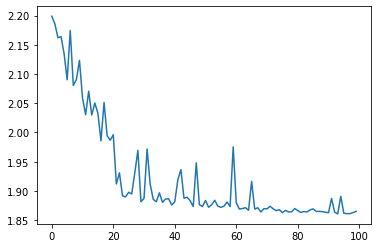

In [ ]:
sns.lineplot(x= range(len(batch_loss)), y= batch_loss);

# -------------------------------------------------

# Saving document embeddings

In [ ]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 1)

In [ ]:
for idx in range(len(doc_idxs)):
    TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_train)
    save_tensor(TRAIN_emb, '../train_document/doc_'+str(idx),"embedding")
    save_tensor(TRAIN_labels, '../train_document/doc_'+str(idx),"label")

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])
Tensor saved to '../train_document/doc_0/embedding'
Tensor saved to '../train_document/doc_0/label'
X_train size: torch.Size([72, 1, 768])	Y_train size: torch.Size([72])
Tensor saved to '../train_document/doc_1/embedding'
Tensor saved to '../train_document/doc_1/label'
X_train size: torch.Size([200, 1, 768])	Y_train size: torch.Size([200])
Tensor saved to '../train_document/doc_2/embedding'
Tensor saved to '../train_document/doc_2/label'
X_train size: torch.Size([119, 1, 768])	Y_train size: torch.Size([119])
Tensor saved to '../train_document/doc_3/embedding'
Tensor saved to '../train_document/doc_3/label'
X_train size: torch.Size([184, 1, 768])	Y_train size: torch.Size([184])
Tensor saved to '../train_document/doc_4/embedding'
Tensor saved to '../train_document/doc_4/label'
X_train size: torch.Size([211, 1, 768])	Y_train size: torch.Size([211])
Tensor saved to '../train_document/doc_5/embedding'
Tensor saved to '../

In [ ]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TEST_data, batch_size= 1)
max_lens_test = max_length(TEST_data)

In [ ]:
for idx in range(len(doc_idxs)):
    TEST_emb, TEST_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_test)
    save_tensor(TEST_emb, '../test_document/doc_'+str(idx),"embedding")
    save_tensor(TEST_labels, '../test_document/doc_'+str(idx),"label")

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])
Tensor saved to '../test_document/doc_0/embedding'
Tensor saved to '../test_document/doc_0/label'
X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])
Tensor saved to '../test_document/doc_1/embedding'
Tensor saved to '../test_document/doc_1/label'
X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])
Tensor saved to '../test_document/doc_2/embedding'
Tensor saved to '../test_document/doc_2/label'
X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])
Tensor saved to '../test_document/doc_3/embedding'
Tensor saved to '../test_document/doc_3/label'
X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])
Tensor saved to '../test_document/doc_4/embedding'
Tensor saved to '../test_document/doc_4/label'
X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])
Tensor saved to '../test_document/doc_5/embedding'
Tensor saved to '../test_document/d

In [ ]:
load_tensor(f"../train_document/doc_{69}/embedding").size()

torch.Size([0, 1, 768])

# Checking LSTM

In [84]:
TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{0}/embedding")
TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{0}/label")

In [85]:
TRAIN_emb.size()

torch.Size([91, 1, 768])

In [86]:
bilstm = nn.LSTM(input_size = 768,
                hidden_size = 128,
                num_layers = 1,
                bidirectional=True)

dense = nn.Sequential(nn.Dropout(p=0.1),
                    nn.Linear(128*2, 128),
                    nn.ReLU(),
                    nn.Linear(128, 13),
                    nn.Softmax(dim=1))

In [87]:
TRAIN_emb = TRAIN_emb.permute(1,0,2)
for i in range(TRAIN_emb.size(-2)):
    if i == 0:
        lstm_out, (hidden,cell) = bilstm(TRAIN_emb[:,i,:])
    else:
        lstm_out, (hidden,cell) = bilstm(TRAIN_emb[:,i,:], (hidden, cell))

In [106]:
out, (hidden,cell) = bilstm(TRAIN_emb.squeeze(0))

In [108]:
out.size()

torch.Size([91, 256])

In [111]:
lstm_out.size()

torch.Size([1, 256])

In [114]:
nn.CrossEntropyLoss()(dense(out),TRAIN_labels)

tensor(2.5638, grad_fn=<NllLossBackward0>)